# Pytorch Segmentation

In [80]:
import torch
import urllib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms



## Download the model

In [81]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()


Using cache found in /home/frank/.cache/torch/hub/pytorch_vision_v0.5.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## read labels for the pretrained model

In [86]:
labels_map = None
with open('../openvino/voc.names', 'r') as f:
    labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
print(labels_map)


['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


## Test the pretrained model

(512, 512)
predicted 15 pottedplant
display


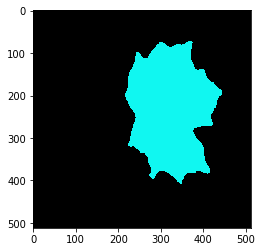

In [89]:
import numpy as np
import cv2
#url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
#try: urllib.URLopener().retrieve(url, filename)
#except: urllib.request.urlretrieve(url, filename)

filename='./norway-maple-leaf-underside.jpg'
print(input_image.size)
input_image = Image.open(filename).resize((512, 512))

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

inputnp = input_tensor.numpy().reshape(512,512,3)

input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if False:#torch.cuda.is_available():
    print("move to cuda")
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

hs,_ = np.histogram(output_predictions.byte().cpu().numpy().flatten(),bins=len(labels_map)+1,range=(0,len(labels_map)+1))
classification = np.argmax(hs[1:])

print("predicted",classification,labels_map[classification])

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)
print("display")

plt.imshow(r)
#plt.show()

## train the model
 source is https://github.com/chenxi116/DeepLabv3.pytorch
 
 not tested yet

### Save the model

In [62]:
torch.save(model.state_dict(), '../model/model_leaf_segmentation_01.pt')

In [65]:
rand_input=torch.randn(1,3,512,512)
torch.onnx.export(model,rand_input,"../model/model_leaf_segmentation_01.onnx", input_names = ['input'],output_names = ['out']) 

### convert it to openvino IR